In [1]:
import pandas as pd
import spacy
import json
import matplotlib.pyplot as plt

In [2]:
import gender_classifier

In [3]:
import nltk
nltk.download('names')

[nltk_data] Downloading package names to
[nltk_data]     /Users/punchaixanien/nltk_data...
[nltk_data]   Package names is already up-to-date!


True

In [4]:
# Load the spacy model
nlp = spacy.load("en_core_web_sm")

In [5]:
# Read agency csv and prepare it for use
agency = pd.read_csv('agency_power.csv')
agency = agency.set_index('verb')

In [6]:
# Identify Verb subject and object from a sentence and return as dictionary
def get_words(text):
  wordlist = {'verb': '.', 'subject': '.', 'object': '.'}
  doc = nlp(text)
  for token in doc:
    if token.dep_ == 'ROOT':
      try:
        wordlist.update({'verb': (token.lemma_ + 's')})
      except:
        pass
    elif token.dep_ == 'nsubj':
      wordlist.update({'subject': token.text})
    elif token.dep_ == 'dobj':
      wordlist.update({'object': token.text})
  return wordlist

In [7]:
# Placeholder classifer (use gender classifier instead)
def classifier(name):
  # returns 0 for female and 1 for male and 2 for unidentifiable
  if name == 'him':
    return 1
  elif name == 'her':
    return 0
  return 2

In [8]:
# Takes in verb/object/subject and agency and outputs list
def evaluate_power_agency(wordlist, agency, classifier):
  # Get the power agency that matches the verb and object
  # [m agency_pos, f agency_pos, m agency_neg, f agency_neg, m power, f power]
  lst = [0, 0, 0, 0, 0, 0]
  objectgender = 2
  subjectgender = 2

  ogender = None
  sgender = None

  try:
    ogender = classifier.classify(wordlist.get('object'))
  except:
    ogender = classifier.nlp_classifier(wordlist.get('object'))
  
  if ogender == 'male':
    objectgender = 1
  elif ogender == 'female':
    objectgender = 0

  try:
    sgender = classifier.classify(wordlist.get('subject'))
  except:
    sgender = classifier.nlp_classifier(wordlist.get('subject'))
  
  if sgender == 'male':
    subjectgender = 1
  elif sgender == 'female':
    subjectgender = 0

  try:
    row = agency.loc[wordlist.get('verb')]
  except:
    return lst
  
  if row.agency == 'agency_pos':
    if subjectgender == 0:
      lst[1] = 1
    elif subjectgender == 1:
      lst[0] = 1
  elif row.agency == 'agency_neg':
    if subjectgender == 0:
      lst[3] = 1
    elif subjectgender == 1:
      lst[2] = 1
  elif row.agency == 'power_agent':
    if subjectgender == 0:
      lst[5] = 1
    elif subjectgender == 1:
      lst[4] = 1
  elif row.agency == 'power_theme':
    if objectgender == 0:
      lst[5] = 1
    elif objectgender == 1:
      lst[4] = 1
  return lst

In [9]:
# Open JSON and get movie script as list of dictionaries
f = open('frozen-json')
data = json.load(f)
f.close()
script = data.get('movie_script')

In [10]:
# Break text chunk into sentences and evaluate them separately
def iterate_text(section, agency, classifier):
  total = [0, 0, 0, 0, 0, 0]
  sentences = section.get('text').split('.')
  for sentence in sentences:
    wordlist = get_words(sentence)
    if wordlist.get('subject') == 'I':
      try:
        wordlist.update({'subject': section.get('character')})
      except:
        pass
    lst = evaluate_power_agency(wordlist, agency, classifier)
    total = [x + y for x, y in zip(total, lst)]
  return total

In [11]:
# Iterate over script and get power agency for each block (based on type)
def iterate_script(script, types, agency, classifier):
  total = [0, 0, 0, 0, 0, 0]
  for i in range(100):
    if script[i].get('type') in types:
      lst = iterate_text(script[i], agency, classifier)
      total = [x + y for x, y in zip(total, lst)]
  return total

In [12]:
classifier = gender_classifier.Gender_classifier()

In [13]:
total = iterate_script(script, ['speech'], agency, classifier)

In [23]:
total

[0, 12, 0, 5, 0, 0]

In [ ]:
def plot_pos_agency(total):
  highest = max(total) + 1

  label = ['Male', 'Female']
  num = [total[0]] + [total[1]]

  plt.ylim(top = highest)
  plt.ylabel('Num of verbs with positive agency')
  barlist = plt.bar(label, num)
  barlist[0].set_color('#ff9eb3')
  barlist[1].set_color('#ffed9c')

In [25]:
def plot_neg_agency(total):
  highest = max(total) + 1

  label = ['Male', 'Female']
  num = [total[2]] + [total[3]]
  plt.ylim(top = highest)
  plt.ylabel('Num of verbs with negative agency')
  barlist = plt.bar(label,num)
  barlist[0].set_color('#ff9eb3')
  barlist[1].set_color('#ffed9c')

In [26]:
def plot_power(total):
  highest = max(total) + 1

  label = ['Male', 'Female']
  num = [total[4]] + [total[5]]
  
  plt.ylim(top = highest)
  plt.ylabel('Num of verbs with power')
  barlist = plt.bar(label,num)
  barlist[0].set_color('#ff9eb3')
  barlist[1].set_color('#ffed9c')

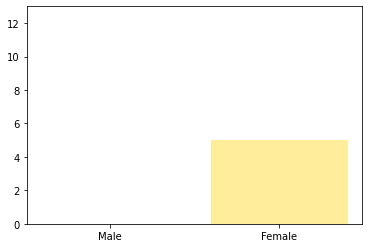

In [27]:
plot_neg_agency(total)

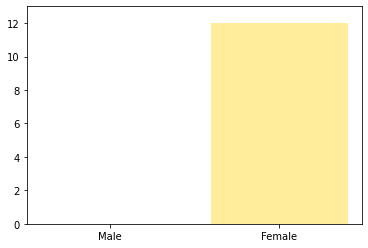

In [28]:
plot_pos_agency(total)

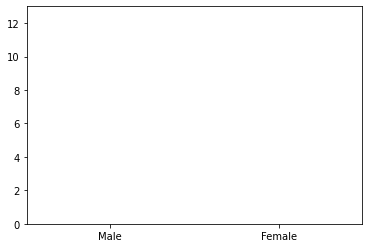

In [29]:
plot_power(total)